#**Implemented By Muhammad Hanan Asghar**

#**Collecting Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Data Look Like**

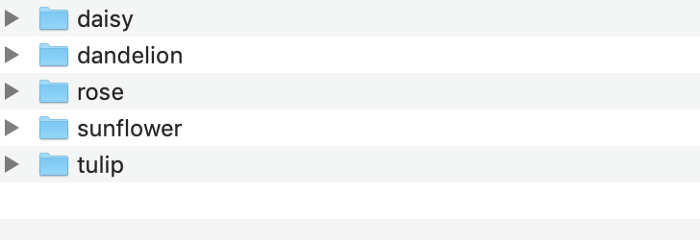

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 96% 430M/450M [00:03<00:00, 79.2MB/s]
100% 450M/450M [00:03<00:00, 143MB/s] 


In [ ]:
# !cp -v -r "/content/flowers-recognition.zip" "/content/drive/MyDrive"

In [ ]:
!unzip "/content/drive/MyDrive/flowers-recognition.zip"

In [4]:
!rm -rf "/content/flowers/flowers"

#**Preprocessing**

In [5]:
import torch


device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


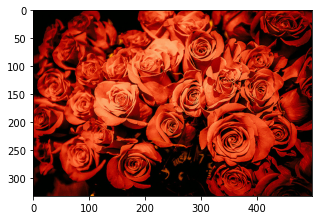

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def show_image(image_path):
  image = Image.open(image_path)
  image_arr = np.array(image)
  plt.figure(figsize=(5, 5))
  plt.imshow(image_arr)


show_image("/content/flowers/rose/10503217854_e66a804309.jpg")

In [7]:
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.autograd import Variable



transformations = transforms.Compose([
                             transforms.Resize((64, 64)),
                             transforms.ToTensor(),
                             transforms.RandomHorizontalFlip(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     
])

total_dataset = datasets.ImageFolder("/content/flowers", transform=transformations)
dataset_loader = DataLoader(dataset=total_dataset, batch_size=100, shuffle=True)
items = iter(dataset_loader)
image, label = items.next()

In [8]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


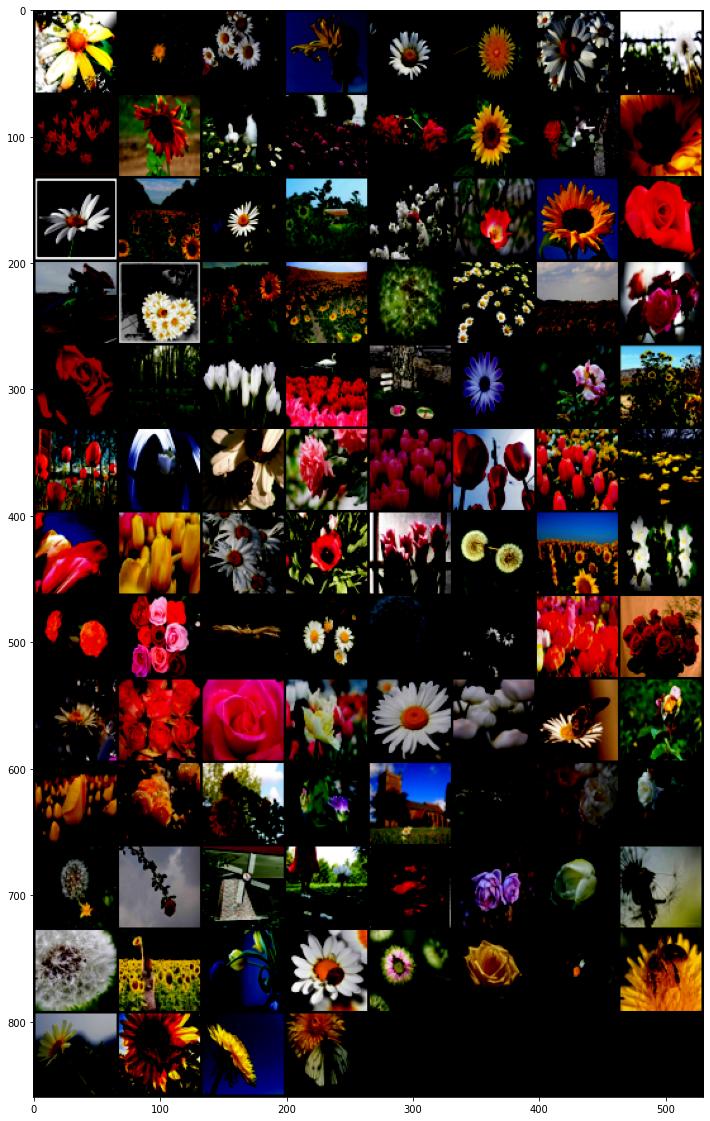

In [9]:
show_transformed_image(make_grid(image))

In [10]:
total_dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Mathematically, if a filter of size kxk is applied on an image of size WxH then it produces an output image/tensor of size 

(W-k+1)x(H-k+1)

#**Seprating Dataset**

In [11]:
from torch.utils.data import random_split


train_size = int(0.87 * len(total_dataset))
test_size = len(total_dataset) - train_size

train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

train_dataset_loader = DataLoader(dataset = train_dataset, batch_size=8, shuffle=True)
test_dataset_loader = DataLoader(dataset = test_dataset, batch_size=8, shuffle=True)

#**Designing Model**

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class FlowerRecognitionCNNModel(nn.Module):
  def __init__(self, num_classes=5):
    super(FlowerRecognitionCNNModel, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    self.norm1 = nn.BatchNorm2d(num_features=12)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.drop1 = nn.Dropout2d(p=0.3)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
    self.norm2 = nn.BatchNorm2d(num_features=24)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.drop2 = nn.Dropout2d(p=0.3)

    self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.norm3 = nn.BatchNorm2d(num_features=32)
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)
    self.drop3 = nn.Dropout2d(p=0.3)

    self.fc1 = nn.Linear(8*8*32, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, out_features=num_classes)

  def forward(self, input):
    output = self.conv1(input)
    output = self.norm1(output)
    output = self.relu1(output)
    output = self.maxpool1(output)
    output = self.drop1(output)

    output = self.conv2(output)
    output = self.norm2(output)
    output = self.relu2(output)
    output = self.maxpool2(output)
    output = self.drop2(output)

    output = self.conv3(output)
    output = self.norm3(output)
    output = self.relu3(output)
    output = self.maxpool3(output)
    output = self.drop3(output)



    output = output.view(-1, 8*8*32)
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.drop3(output)
    output = self.fc3(output)
    return output

In [13]:
import torch.optim as optim


cnn_model = FlowerRecognitionCNNModel().to(device)
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

#**Training**

In [14]:
train_count = len(train_dataset_loader.dataset)
test_count = len(test_dataset_loader.dataset)
print(train_count, test_count)

3761 562


In [15]:
import time

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
def train_n_build(n_epochs):
  best_accuracy = 0.0
  for epoch in range(n_epochs):
    start = time.time()
    cnn_model.train()

    train_accuracy=0.0
    train_loss=0.0


    for i,(images, labels) in enumerate(train_dataset_loader):
      if torch.cuda.is_available():
        images=Variable(images.to(device))
        labels=Variable(labels.to(device))
      optimizer.zero_grad()
      outputs = cnn_model(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.cpu().data*images.size(0)
      _, prediction = torch.max(outputs.data,1)

      train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    cnn_model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_dataset_loader):
      if torch.cuda.is_available():
        images=Variable(images.to(device))
        labels=Variable(labels.to(device))

      outputs = cnn_model(images)
      _, prediction = torch.max(outputs.data, 1)
      test_accuracy += int(torch.sum(prediction == labels.data))
    
    test_accuracy = test_accuracy/test_count

    close = time.time()
    print('Epoch: '+str(epoch)+', Time: '+str(round(close - start, 2))+'s, Train Loss: '+str(train_loss.item())+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    if test_accuracy>best_accuracy:
      torch.save(cnn_model.state_dict(), 'best_checkpoint.model')
      best_accuracy = test_accuracy
    
    if (best_accuracy > 0.85) or (train_accuracy > 0.95):
      break

In [17]:
train_n_build(200)

Epoch: 0, Time: 15.07s, Train Loss: 1.5187684297561646 Train Accuracy: 0.30949215634139854 Test Accuracy: 0.5142348754448398
Epoch: 1, Time: 14.87s, Train Loss: 1.3291020393371582 Train Accuracy: 0.4219622440840202 Test Accuracy: 0.4804270462633452
Epoch: 2, Time: 14.97s, Train Loss: 1.2517417669296265 Train Accuracy: 0.4724807232119117 Test Accuracy: 0.5409252669039146
Epoch: 3, Time: 15.05s, Train Loss: 1.2396104335784912 Train Accuracy: 0.48311619250199417 Test Accuracy: 0.5889679715302492
Epoch: 4, Time: 14.92s, Train Loss: 1.1973899602890015 Train Accuracy: 0.5073118851369317 Test Accuracy: 0.5693950177935944
Epoch: 5, Time: 14.9s, Train Loss: 1.163769245147705 Train Accuracy: 0.5192767880882744 Test Accuracy: 0.6120996441281139
Epoch: 6, Time: 14.92s, Train Loss: 1.1346434354782104 Train Accuracy: 0.5535761765487902 Test Accuracy: 0.599644128113879
Epoch: 7, Time: 14.96s, Train Loss: 1.1091307401657104 Train Accuracy: 0.5493219888327573 Test Accuracy: 0.5871886120996441
Epoch: 8,

KeyboardInterrupt: ignored

In [21]:
 def predict_image(image):
    image_tensor = transformations(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn_model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [30]:
from google.colab.patches import cv2_imshow

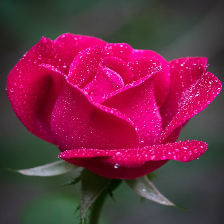

In [33]:
import cv2
img = cv2.imread('/content/rosepic12.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)

In [23]:
from PIL import Image

image = Image.open("/content/rosepic12.jpg")

predict_image(image)

2

In [24]:
print("{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}")

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


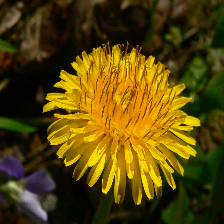

In [34]:
import cv2
img = cv2.imread('/content/DandelionFlower.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)

In [25]:
from PIL import Image

image = Image.open("/content/DandelionFlower.jpg")

predict_image(image)

1

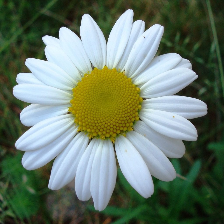

In [39]:
import cv2
img = cv2.imread('/content/Oxeye-daisy-flower_3859338724_o.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)

In [27]:
from PIL import Image

image = Image.open("/content/Oxeye-daisy-flower_3859338724_o.jpg")

predict_image(image)

0

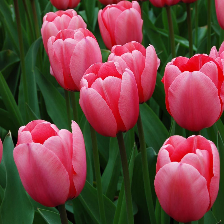

In [41]:
import cv2
img = cv2.imread('/content/25440.Jpg', cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)

In [28]:
from PIL import Image

image = Image.open("/content/25440.Jpg")

predict_image(image)

4